# 1、读取 abaqus inp 文件，展示节点信息图

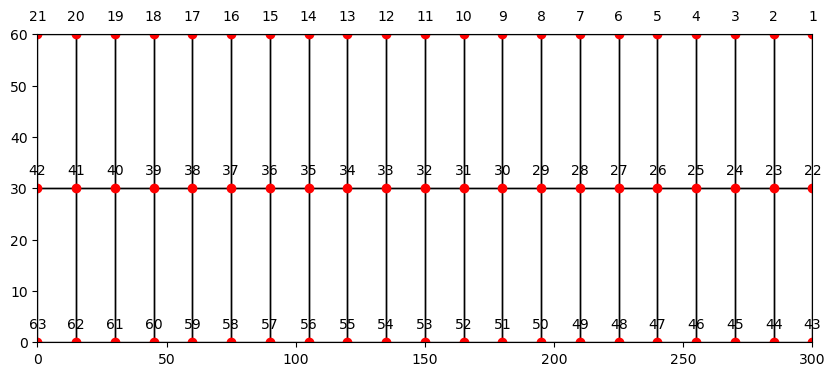

In [1]:
# Show nodes
import DM_ShowNodes as DMshow
file_path = "E:\phd\Code\DM-FEM2D\Fem_inp\Job-1_largemesh.inp"
label_interval = 1
node = DMshow.plot_fea_model(file_path, label_interval)
#node_ids = [41, 39, 37, 35, 33, 31, 29, 27, 25, 23]

# 2、读取abaqus到处的有限元质量矩阵和刚度矩阵

In [2]:
import DM_Reading as dm_r
file_m = 'Job-1_largemesh_MASS1.mtx'
file_k = 'Job-1_largemesh_STIF1.mtx'

In [3]:
M = dm_r.get_stiffness_matrix(file_m)
k = dm_r.get_stiffness_matrix(file_k)

## 2.1为了解决M矩阵对角线存在0值，在对角线上添加小量进行计算。

In [4]:
import numpy as np
epsilon = 1e-6  # This is the small quantity you choose to add
np.fill_diagonal(M, np.diagonal(M) + epsilon)

### Eigenvalues 特征值 eigenvector 特征向量
### The eigenvectors are returned in a 2D array, where each column corresponds to an eigenvector associated with the eigenvalue at the same index. For example, the first column corresponds to the first (smallest) eigenvalue, the second column to the second eigenvalue, and so on.

# 3、使用python复现SEREP函数方法

In [9]:
# 为了快速读取SlaveDofs而创建的函数
import numpy as np
def create_dof_matrix(num_nodes, nodes_to_remove):
    """
    Create a DOF matrix for a system with a specified number of nodes,
    each having 6 DOFs, and remove the DOFs corresponding to specified nodes.

    Parameters:
    num_nodes (int): Number of nodes in the system.
    nodes_to_remove (list): List of node IDs whose DOFs are to be removed.

    Returns: 
    numpy.ndarray: A matrix with remaining DOFs.
    """
    # Each node has 6 DOFs
    total_dofs = num_nodes * 6

    # Initialize an array to represent all DOFs
    dof_array = np.arange(total_dofs)

    # Adjust the nodes_to_remove to zero-based indexing
    nodes_to_remove_zero_based = [node - 1 for node in nodes_to_remove]

    # Calculate the DOF indices for the nodes to remove
    dofs_to_remove = []
    for node_id in nodes_to_remove_zero_based:
        start_dof = node_id * 6
        dofs_to_remove.extend(range(start_dof, start_dof + 6))

    # Remove the specified DOFs
    remaining_dofs = np.delete(dof_array, dofs_to_remove)

    return np.array(remaining_dofs)

# Example usage
num_nodes = 63
nodes_to_remove = [41, 39, 37, 35, 33, 31, 29, 27, 25, 23]
SlaveDofs = create_dof_matrix(num_nodes, nodes_to_remove)
SlaveDofs.shape

(318,)

In [10]:
import numpy as np
from scipy.linalg import eigh

def SEREP(K, M, SlaveDofs):
    # Sort the SlaveDofs
    SlaveDofs = np.sort(SlaveDofs)
    
    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh(K, M)
    
    # Create index array for remaining DOFs
    index = np.setdiff1d(np.arange(K.shape[0]), SlaveDofs)

    # Define transformation matrices
    Am = eigenvectors[:, index]
    # print(Am.shape)
    As = eigenvectors[:, SlaveDofs]
    # print(As.shape)
    test = np.hstack((Am, As))
    # print(test.shape)
          
    T = np.dot(np.dot(np.hstack((Am, As)), np.dot(Am, Am.T)), Am)
    # print("T的shape:",T.shape)

    # Calculate the reduced mass and stiffness matrices
    MR = T.T @ M @ T
    KR = T.T @ K @ T
    
    return KR, MR, T

# Example usage:
# Assuming K, M are your full stiffness and mass matrices and
# SlaveDofs is a list/array of DOFs to delete
# SlaveDofs = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
KR, MR, T = SEREP(k, M, SlaveDofs)


# 4、读取水动力数据，构建运动方程，求解位移响应

In [11]:
#import packages
import time
import numpy as np
import capytaine as cpt
import scipy
from capytaine.io.mesh_writers import write_STL
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import vtk
import logging
import xarray as xr
from capytaine.io.xarray import merge_complex_values
from capytaine.post_pro import rao
logging.basicConfig(level=logging.INFO, format='%(levelname)-8s: %(message)s')

In [12]:
dataset = merge_complex_values(xr.open_dataset("E:\phd\Code\DM-FEM2D\winddata\DM10_180_direction0.nc"))

In [36]:
# Extract matrices and force from the dataset
added_mass = dataset['added_mass'][0].values
radiation_damping = dataset['radiation_damping'][0].values
inertia_matrix = dataset['inertia_matrix'].values
hydrostatic_stiffness = dataset['hydrostatic_stiffness'].values
F_w = dataset['Froude_Krylov_force'][0].values + dataset['diffraction_force'][0].values

In [43]:
mass = added_mass + MR
damping = radiation_damping
stiffness = hydrostatic_stiffness + KR

In [44]:
import DM_Assemble as DM_A
omega = 0.5754  # Here we use 1.0 as an example, in actual applications you should use your real data
X = DM_A.solve_frequency_domain(mass, damping, stiffness, F_w, omega)  # Solve in frequency domain

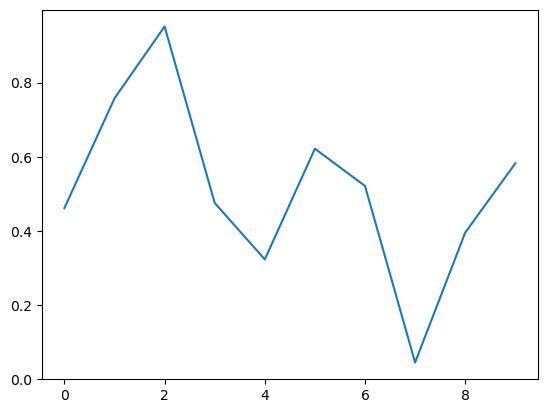

In [45]:
import matplotlib.pyplot as plt
heave = abs(X[2::6])
plt.plot(heave)

# 原模型结果vailation
！![Alt text](image.png)